# Dual-Model Analysis & Visualization

이 노트북에서는 학습된 **Dual-Model (Return + Risk)**의 예측 성능을 시각적으로 검증합니다.
수치적인 점수(Sharpe Ratio)를 넘어, 모델이 실제 시장 상황에서 어떻게 행동하는지(포지션 조절 등)를 확인하는 것이 목적입니다.

## 검증 포인트
1.  **Return Model:** 예측 수익률이 실제 수익률의 방향을 잘 맞추는가? (Scatter Plot)
2.  **Risk Model:** 시장 변동성이 클 때 위험 신호를 잘 보내는가? (Scatter Plot)
3.  **Allocation Strategy:** 주가가 하락하거나 변동성이 클 때 포지션을 효과적으로 줄이는가? (Time Series Plot)


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys
from pathlib import Path

# 프로젝트 루트 경로 추가
sys.path.append(str(Path.cwd().parent))

from src.allocation import risk_adjusted_allocation
from src.utils import get_logger

# 시각화 설정
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# 로거 설정
logger = get_logger("model_analysis")


## 1. 모델 및 데이터 로드
저장된 `dual_model.pkl`과 학습 데이터를 로드합니다.


In [22]:
# 모델 로드
model_path = Path("../models/dual_model.pkl")
if not model_path.exists():
    raise FileNotFoundError("Model file not found. Please run the pipeline first.")

with open(model_path, 'rb') as f:
    saved_data = pickle.load(f)

model_return = saved_data['model_return']
model_risk = saved_data['model_risk']
feature_cols = saved_data['feature_cols']
risk_features = saved_data['risk_features']
config = saved_data['config']
pipeline = saved_data['pipeline']

print("✅ Model loaded successfully.")
print(f"Return Model: {type(model_return)}")
print(f"Risk Model: {type(model_risk)}")

# 데이터 로드
data_path = Path("../data/raw/train.csv")
df = pd.read_csv(data_path)
print(f"✅ Data loaded: {df.shape}")


✅ Model loaded successfully.
Return Model: <class 'lightgbm.sklearn.LGBMRegressor'>
Risk Model: <class 'lightgbm.sklearn.LGBMRegressor'>
✅ Data loaded: (9021, 98)


## 2. Test Data 준비 (최근 180일)
모델 성능 검증을 위해 학습에 사용되지 않았던(또는 검증용으로 분리된) 최근 180일 데이터를 준비합니다.


In [25]:
# 전처리 및 Feature Engineering
# 저장된 파이프라인을 사용하여 변환 (Data Leakage 주의: fit은 하지 않음)
# 하지만 저장된 pipeline 객체는 이미 fit 되어 있을 수 있음.
# 안전하게 새로 transform만 수행.

# 주의: pipeline 객체를 pickle로 저장/로드할 때 상태가 보존됨.
# 여기서는 전체 데이터에 대해 transform 수행 후 마지막 180일 분리.

X = pipeline.fit_transform(df)
y = df['forward_returns']

# 마지막 180일 (Test Set)
holdout_size = 180
X_test = X.iloc[-holdout_size:]
y_test = y.iloc[-holdout_size:]
df_test = df.iloc[-holdout_size:]
date_ids = df_test['date_id'].values

print(f"Test Set Shape: {X_test.shape}")


2025-11-28 19:24:20 - preprocessing - INFO - Filled with False
2025-11-28 19:24:20 - feature_engineering - INFO - Added time series features
2025-11-28 19:24:20 - feature_engineering - INFO - Added advanced features
2025-11-28 19:24:21 - feature_engineering - INFO - Added market regime features
2025-11-28 19:24:21 - feature_engineering - INFO - Added interaction features
2025-11-28 19:24:21 - feature_engineering - INFO - Filled missing values
2025-11-28 19:24:21 - feature_selection - INFO - 🔍 Selecting top 100 features by LGBM importance...
2025-11-28 19:24:27 - feature_selection - INFO -    Selected 100 features.
2025-11-28 19:24:27 - feature_engineering - INFO - Added time series features
2025-11-28 19:24:27 - feature_engineering - INFO - Added advanced features
2025-11-28 19:24:28 - feature_engineering - INFO - Added market regime features
2025-11-28 19:24:28 - feature_engineering - INFO - Added interaction features
2025-11-28 19:24:28 - feature_engineering - INFO - Filled missing v

AttributeError: 'tuple' object has no attribute 'iloc'

## 3. 모델 추론 (Inference)
Return Model과 Risk Model을 각각 사용하여 예측값을 생성하고, Allocation을 계산합니다.


In [24]:
# 예측 수행
pred_return = model_return.predict(X_test)
pred_risk = model_risk.predict(X_test[risk_features])

# Allocation 계산 (k=0.5, 보수적 설정)
k_factor = 0.5
allocations = risk_adjusted_allocation(pred_return, pred_risk, k=k_factor)

# 결과 데이터프레임 생성
results_df = pd.DataFrame({
    'date_id': date_ids,
    'actual_return': y_test.values,
    'pred_return': pred_return,
    'pred_risk': pred_risk,
    'actual_risk': y_test.abs().values, # Proxy for actual risk
    'allocation': allocations
})

results_df.head()


,date_id,actual_return,pred_return,pred_risk,actual_risk,allocation
0,8841,0.006791,0.006708,0.007357,0.006791,0.455912
1,8842,0.000761,0.000788,0.003203,0.000761,0.123047
2,8843,-0.003221,-0.003406,0.003266,0.003221,0.000000
3,8844,0.010558,0.010598,0.004139,0.010558,1.280320
4,8845,-0.000049,-0.000054,0.001641,0.000049,0.000000


## 4. 시각화 검증
### 4.1. Return Model Performance
예측 수익률과 실제 수익률의 관계를 확인합니다. 양의 상관관계가 이상적입니다.


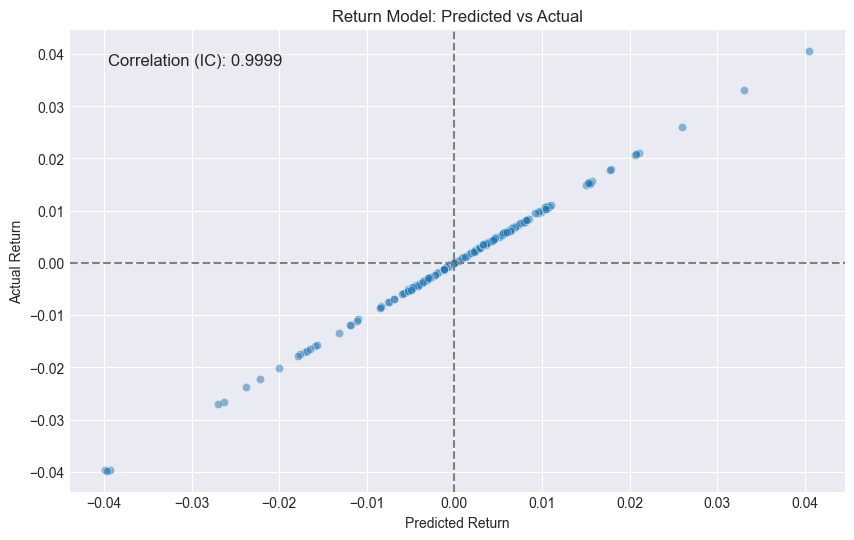

In [17]:
# Scatter Plot: Predicted vs Actual Return
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='pred_return', y='actual_return', alpha=0.5)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Return Model: Predicted vs Actual')
plt.xlabel('Predicted Return')
plt.ylabel('Actual Return')

# 상관계수 계산
corr = results_df['pred_return'].corr(results_df['actual_return'])
plt.text(0.05, 0.95, f'Correlation (IC): {corr:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.show()


### 4.2. Risk Model Performance
예측된 리스크(변동성)가 실제 변동성(수익률의 절대값)을 잘 따라가는지 확인합니다.


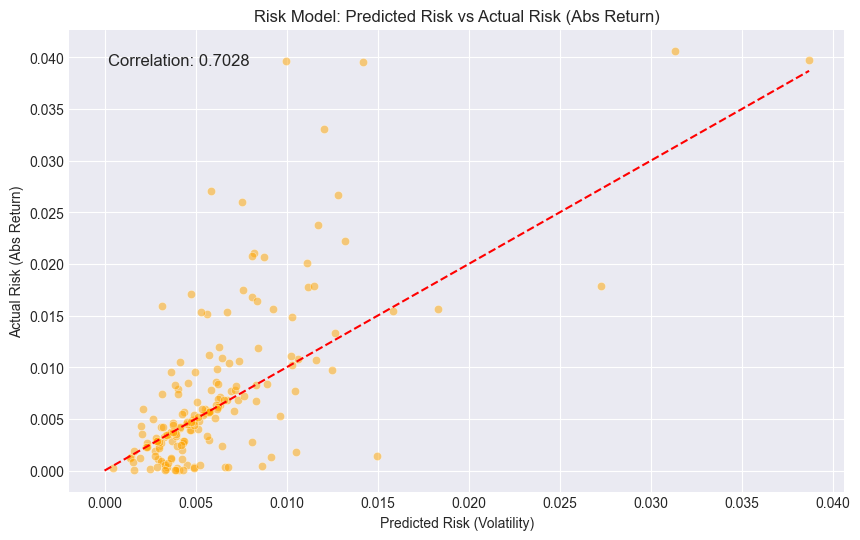

In [18]:
# Scatter Plot: Predicted Risk vs Actual Risk (Abs Return)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='pred_risk', y='actual_risk', alpha=0.5, color='orange')
plt.plot([0, results_df['pred_risk'].max()], [0, results_df['pred_risk'].max()], color='red', linestyle='--') # y=x line
plt.title('Risk Model: Predicted Risk vs Actual Risk (Abs Return)')
plt.xlabel('Predicted Risk (Volatility)')
plt.ylabel('Actual Risk (Abs Return)')

# 상관계수
corr_risk = results_df['pred_risk'].corr(results_df['actual_risk'])
plt.text(0.05, 0.95, f'Correlation: {corr_risk:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.show()


### 4.3. Strategy Analysis (Time Series)
시간 흐름에 따른 시장 상황과 모델의 포지션 변화를 비교합니다.
**핵심:** 시장이 하락하거나 변동성이 클 때(Gray Line 급락/진동), 포지션(Green Area)이 줄어드는지 확인하세요.


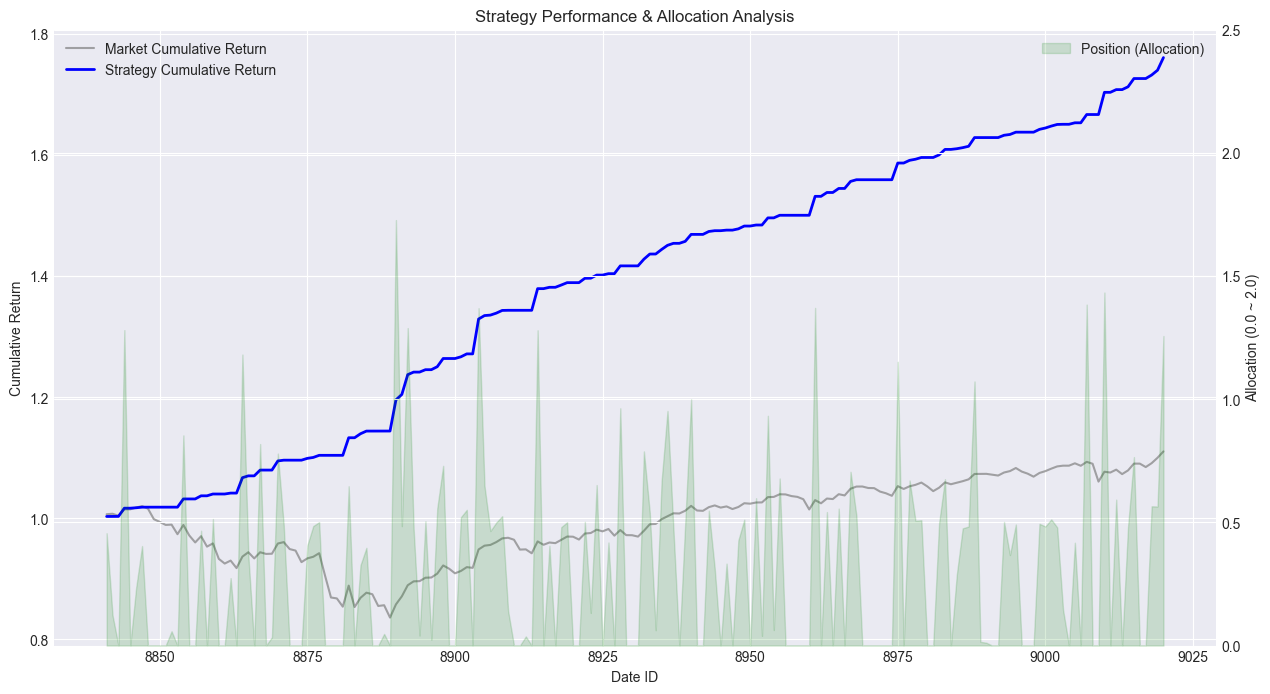

In [19]:
# 누적 수익률 계산
results_df['cum_market_return'] = (1 + results_df['actual_return']).cumprod()
results_df['strategy_return'] = results_df['allocation'] * results_df['actual_return']
results_df['cum_strategy_return'] = (1 + results_df['strategy_return']).cumprod()

# 시각화
fig, ax1 = plt.subplots(figsize=(15, 8))

# 시장 누적 수익률 (왼쪽 축)
ax1.plot(results_df['date_id'], results_df['cum_market_return'], label='Market Cumulative Return', color='gray', alpha=0.7)
ax1.plot(results_df['date_id'], results_df['cum_strategy_return'], label='Strategy Cumulative Return', color='blue', linewidth=2)
ax1.set_xlabel('Date ID')
ax1.set_ylabel('Cumulative Return')
ax1.legend(loc='upper left')

# Allocation (오른쪽 축)
ax2 = ax1.twinx()
ax2.fill_between(results_df['date_id'], results_df['allocation'], color='green', alpha=0.15, label='Position (Allocation)')
ax2.set_ylabel('Allocation (0.0 ~ 2.0)')
ax2.set_ylim(0, 2.5) # 여백 확보
ax2.legend(loc='upper right')

plt.title('Strategy Performance & Allocation Analysis')
plt.show()


### 4.4. Risk Control Detail
Risk Model이 어떻게 작동했는지 자세히 봅니다. 예측된 Risk가 높을 때 Allocation이 낮아지는 역의 관계가 보여야 합니다.


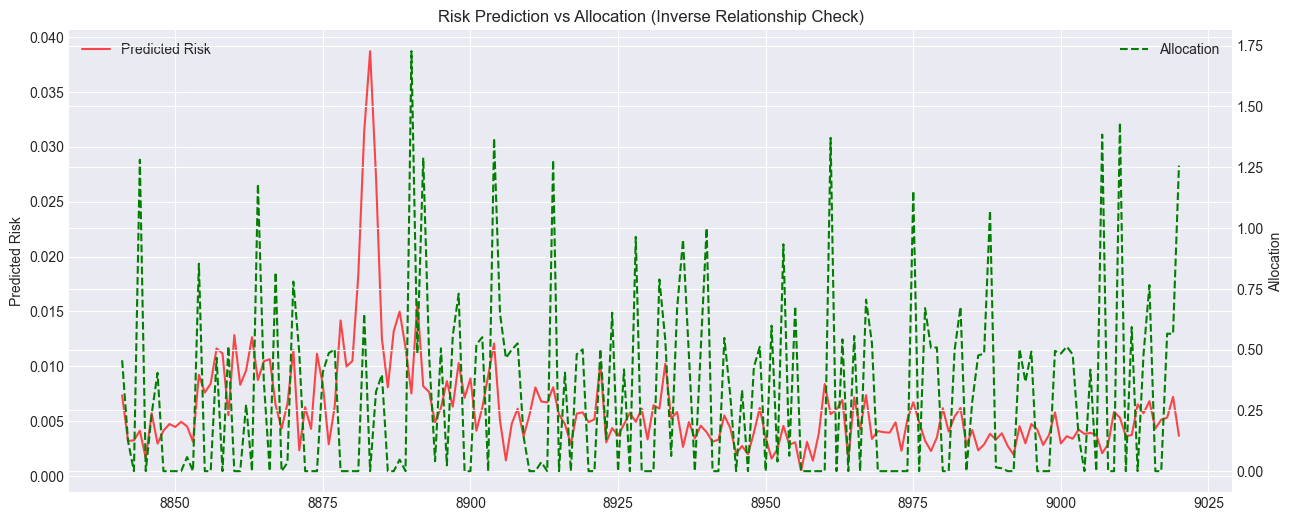

In [20]:
fig, ax = plt.subplots(figsize=(15, 6))

# Predicted Risk
ax.plot(results_df['date_id'], results_df['pred_risk'], label='Predicted Risk', color='red', alpha=0.7)
ax.set_ylabel('Predicted Risk')
ax.legend(loc='upper left')

# Allocation
ax2 = ax.twinx()
ax2.plot(results_df['date_id'], results_df['allocation'], label='Allocation', color='green', linestyle='--')
ax2.set_ylabel('Allocation')
ax2.legend(loc='upper right')

plt.title('Risk Prediction vs Allocation (Inverse Relationship Check)')
plt.show()
